In [5]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv(r'input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

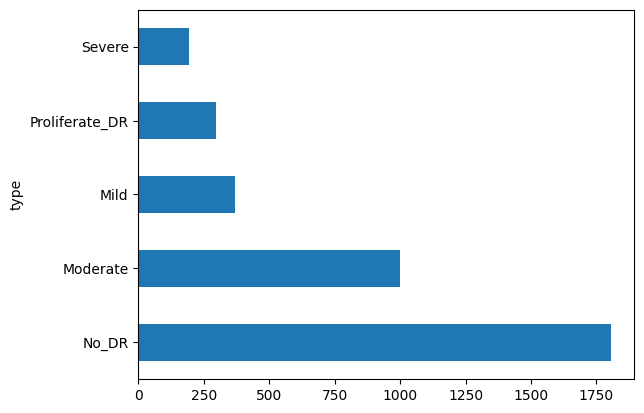

In [7]:
df['type'].value_counts().plot(kind='barh')

In [8]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
print("For Testing Dataset :")
print(test['type'].value_counts(), '\n')
print("For Validation Dataset :")
print(val['type'].value_counts(), '\n')

For Training Dataset :
type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

For Testing Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

For Validation Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [9]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [10]:
src_dir = r'input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [11]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [12]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=15,
                    validation_data=val_batches)


Epoch 1/15



81/81 [==============================] - 51s 573ms/step - loss: 0.3142 - acc: 0.8966 - val_loss: 0.7745 - val_acc: 0.5073
Epoch 2/15
81/81 [==============================] - 19s 229ms/step - loss: 0.1947 - acc: 0.9309 - val_loss: 0.6139 - val_acc: 0.8127
Epoch 3/15
81/81 [==============================] - 19s 228ms/step - loss: 0.1373 - acc: 0.9493 - val_loss: 0.5048 - val_acc: 0.8618
Epoch 4/15
81/81 [==============================] - 19s 230ms/step - loss: 0.0977 - acc: 0.9680 - val_loss: 0.3541 - val_acc: 0.9127
Epoch 5/15
81/81 [==============================] - 19s 228ms/step - loss: 0.0589 - acc: 0.9820 - val_loss: 0.4443 - val_acc: 0.8055
Epoch 6/15
81/81 [==============================] - 19s 232ms/step - loss: 0.0203 - acc: 0.9938 - val_loss: 0.5411 - val_acc: 0.8218
Epoch 7/15
81/81 [==============================] - 20s 242ms/step - loss: 0.0169 - acc: 0.9953 - val_loss: 0.1828 - val_acc: 0.9473
Epoch 8/15
81/81 [==============================] - 19s 230ms/step - loss: 0.016

In [19]:
model.save('64x3-CNN.model')
#model.save("model.h5")


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


In [20]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

C:\Users\ajmal\AppData\Local\Temp\ipykernel_8068\1501885792.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 3s 149ms/step - loss: 0.5077 - acc: 0.9273
Loss:  0.5076774954795837
Accuracy:  0.9272727370262146


In [2]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('Diabetic Retinopathy Not Detected')
    else:
        print('Diabetic Retinopathy Detected')


# Load the model using tf.saved_model.load
#model = tf.saved_model.load("64x3-CNN.model")

# Print the signatures of the model
#print(list(model.signatures.keys()))

# Inspect the default signature
#print(model.signatures['serving_default'])



['serving_default']
ConcreteFunction Input Parameters:
  conv2d_input (KEYWORD_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='conv2d_input')
Output Type:
  Dict[['dense_1', TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_1')]]
Captures:
  1622192937040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192936512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192935984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192935456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192934928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192934400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192933872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192933344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192932816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192932288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1622192931760: TensorSpec(shape=(), dtype=tf.res

1/1 [==============================] - 0s 285ms/step
Diabetic Retinopathy Detected


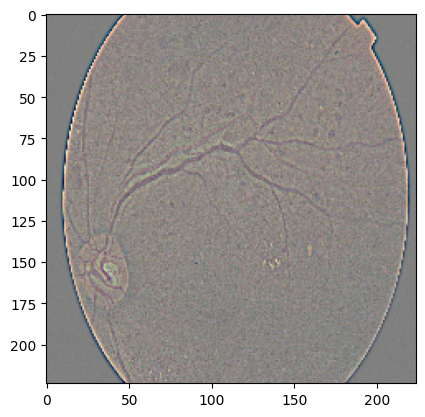

In [23]:
predict_class('input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Severe/1b495ac025b7.png')

1/1 [==============================] - 0s 261ms/step
Diabetic Retinopathy Detected


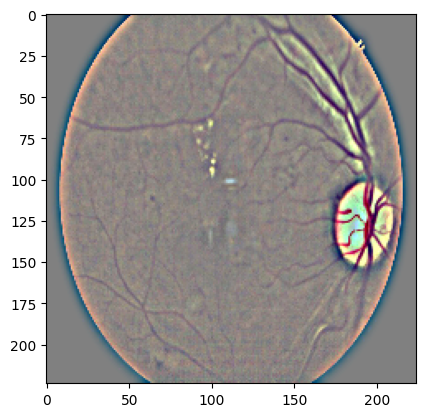

In [17]:
predict_class('input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/1d11794057ff.png')

1/1 [==============================] - 0s 257ms/step
Diabetic Retinopathy Not Detected


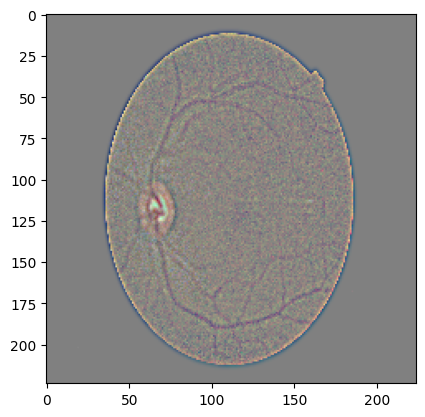

In [18]:
predict_class('input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/No_DR/005b95c28852.png')

In [1]:
# Load the model using tf.saved_model.load
model = tf.saved_model.load("64x3-CNN.model")

# Print the signatures of the model
print(list(model.signatures.keys()))

# Inspect the default signature
print(model.signatures['serving_default'])


NameError: name 'tf' is not defined